In [ ]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data.dataloader import DataLoader, Dataset
from torchvision.io import decode_image
from torchvision.transforms import Resize
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_float32_matmul_precision('medium')

In [2]:
class GlobalStreetscapesSample(Dataset):
    def __init__(self, dataset):
        self.img_labels = dataset
        self.resize = Resize(size=(224, 224))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join("../", self.img_labels.iloc[idx].loc["path"])
        image = decode_image(img_path, apply_exif_orientation=True)
        label = int(self.img_labels.iloc[idx].loc["label"])
        image = self.resize(image)
        return image, label

In [ ]:
samples = pd.read_csv('../../data/imgs/sampled.csv', index_col=0)
paths = pd.read_csv('../../data/img_paths.csv', index_col=0)
img_labels = samples.join(paths, on='uuid', how='inner')

print("samples rows:",samples.shape[0])
print("paths rows:",paths.shape[0])
print("img_labels rows:",img_labels.shape[0])

train_ratio = 0.8
train_df, test_df = train_test_split(img_labels, train_size=train_ratio, stratify=img_labels['label'])

display(train_df.head())

training_data = GlobalStreetscapesSample(
    train_df
)

test_data = GlobalStreetscapesSample(
    test_df
)

# Use num_workers for parallel data loading and pin_memory for faster GPU transfer
# Adjusted num_workers to 8 (approx matching CPU cores) to avoid overhead
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True, num_workers=8, pin_memory=True)

samples rows: 190693
paths rows: 200656
img_labels rows: 190689


,uuid,source,orig_id,city,country,iso3,lat,lon,s2_cell_id,label,path
62134,8b3cbb63-2767-4d15-b820-5118b4d24e54,Mapillary,195437612919918,Washington,United States,USA,38.900988,-77.024493,9923602142432591872,29,../data/imgs/a418b851-b912-4b86-9800-92726da72...
113455,238fe688-f097-4457-882d-dc19aba4cbee,Mapillary,1187939261782206,Washington,United States,USA,38.905879,-77.023969,9923602533274615808,23,../data/imgs/308768fb-bf80-4460-9738-cfb7b3e72...
1287,6b6380ba-d130-46cd-91e3-c49863516f41,Mapillary,454975756669822,Washington,United States,USA,38.902527,-77.031779,9923602157464977408,111,../data/imgs/35fa9773-14ea-4fed-90ec-20cff92ae...
105634,51faa6b2-a1cd-40ae-b0a2-c76c92947cec,Mapillary,748187606246364,Washington,United States,USA,38.895571,-77.026019,9923602136258576384,34,../data/imgs/e01822a0-468d-44b1-aa00-8466632d3...
41522,d41b65cc-d043-412b-b22f-dbce176aa053,Mapillary,3245650225724543,Washington,United States,USA,38.899490,-77.014349,9923602114783739904,47,../data/imgs/d811e2dc-ec73-4d1d-a192-1d431dfb4...


Washington


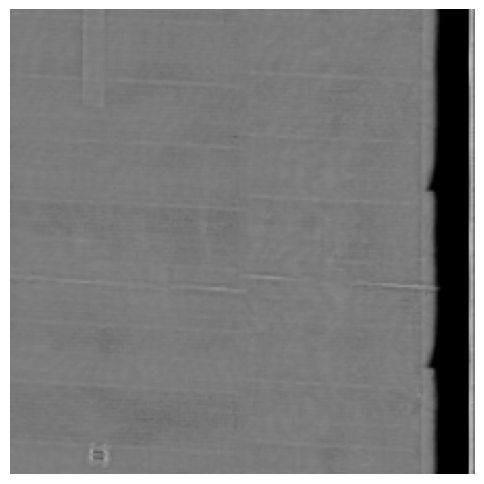

In [4]:
p = os.path.join("../", training_data.img_labels.iloc[10].loc["path"])
print(training_data.img_labels.iloc[10].loc["city"])
img = Image.open(p).convert("RGB")
img = img.resize((224, 224))
plt.figure(figsize=(6,10))
plt.imshow(img)
plt.axis("off")
plt.show()

In [ ]:
# ResNet-50 Docs: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
weights = ResNet50_Weights.DEFAULT
transform = weights.transforms()

model = resnet50(weights=weights)

# ResNet classifier is a Linear layer named 'fc'.
in_features = model.fc.in_features
num_classes = img_labels.label.nunique()

# Replace the default number of classes
print(f"Previous head: {model.fc}")
model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes)
print(f"New head: {model.fc}")
print(f"Number of classes: {num_classes}")

# Move to device with Channels Last memory format (Optimized for NVIDIA GPUs)
model = model.to(device, memory_format=torch.channels_last)
model = torch.compile(model)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:00<00:00, 408MB/s] 


Previous head: Linear(in_features=768, out_features=1000, bias=True)
Previous head: Linear(in_features=768, out_features=144, bias=True)
Number of classes: 144
Using device: cuda


In [ ]:
num_epochs = 20
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Changed to OneCycleLR with 10% warmup
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-4,
    steps_per_epoch=len(train_dataloader),
    epochs=num_epochs,
    pct_start=0.1  # 10% of total steps used for warmup
)

# Initialize GradScaler for Automatic Mixed Precision (AMP)
# Updated to new torch.amp API
scaler = torch.amp.GradScaler('cuda')

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"EPOCH: {epoch+1}")

    # --- Training Phase ---
    current_loss = 0
    model.train()
    for inputs, labels in tqdm(train_dataloader, desc="Training"):
        # Move to GPU with non_blocking and channels_last memory format
        inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        
        optimizer.zero_grad()
        
        # Runs the forward pass with autocasting (FP16)
        with torch.amp.autocast('cuda'):
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
        
        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()
        
        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called,
        # otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)
        
        # Updates the scale for next iteration.
        scaler.update()
        
        scheduler.step() 
        
        current_loss += loss.item()
    
    avg_train_loss = current_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    
    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_dataloader, desc="Validation", leave=False):
            inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
            labels = labels.to(device, non_blocking=True)
            
            inputs = transform(inputs)
            
            # AMP for validation as well
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
            running_val_loss += loss.item()
            
    avg_val_loss = running_val_loss / len(test_dataloader)
    val_losses.append(avg_val_loss)

    print(f"Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}")
    
    torch.save(model.state_dict(), f'resnet50_epoch{epoch}.pth')

EPOCH: 1


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 4.141 (4.141)
LR: 0.000052
EPOCH: 2


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 2.359 (3.250)
LR: 0.000100
EPOCH: 3


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.760 (2.753)
LR: 0.000099
EPOCH: 4


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.446 (2.426)
LR: 0.000097
EPOCH: 5


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.238 (2.189)
LR: 0.000093
EPOCH: 6


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 1.083 (2.004)
LR: 0.000088
EPOCH: 7


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.977 (1.858)
LR: 0.000082
EPOCH: 8


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.913 (1.740)
LR: 0.000075
EPOCH: 9


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.878 (1.644)
LR: 0.000067
EPOCH: 10


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.858 (1.565)
LR: 0.000059
EPOCH: 11


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.853 (1.500)
LR: 0.000050
EPOCH: 12


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.844 (1.446)
LR: 0.000041
EPOCH: 13


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.837 (1.399)
LR: 0.000033
EPOCH: 14


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.828 (1.358)
LR: 0.000025
EPOCH: 15


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.824 (1.322)
LR: 0.000018
EPOCH: 16


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.822 (1.291)
LR: 0.000012
EPOCH: 17


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.264)
LR: 0.000007
EPOCH: 18


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.239)
LR: 0.000003
EPOCH: 19


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.217)
LR: 0.000001
EPOCH: 20


  0%|          | 0/596 [00:00<?, ?it/s]

Loss: 0.821 (1.197)
LR: 0.000000


In [ ]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, marker='s', label='Validation Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        inputs = transform(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_dataloader)
accuracy = 100 * correct / total

print(f"Test Loss: {avg_test_loss:.3f}")
print(f"Test Accuracy: {accuracy:.2f}%")

  0%|          | 0/149 [00:00<?, ?it/s]

Test Loss: 1.505
Test Accuracy: 81.82%


In [ ]:
from sklearn.metrics import classification_report

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_dataloader, desc="Class Report"):
        inputs = inputs.to(device, non_blocking=True, memory_format=torch.channels_last)
        labels = labels.to(device, non_blocking=True)
        
        inputs = transform(inputs)
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Print classification report with 3 digits of precision
print(classification_report(y_true, y_pred, digits=3))